# Generate attributes of bounding boxes from detection

需要的代码文件和配置：
- yolov3仓库：https://github.com/JinhangZhu/yolov3/tree/custom
- ego-hand对应的配置文件：https://github.com/JinhangZhu/yolov3/blob/custom/cfg/yolov3-hand-anchors.cfg
- 类名文件：https://github.com/JinhangZhu/yolov3/blob/custom/data/ego-hand.names
- 权重文件：https://drive.google.com/drive/folders/1eniPof1xZXXeTQtPT0fEfpf1ci14ldf5?usp=sharing

In [2]:
# 在ego-hand数据集上训练得到了训练4迭代期的权重：yolov3-egohand-epoch4.pt，其在valid set做评估效果达到了0.848mAP，暂时可用来做生成bbox位置信息和分类标签的模型雏形

In [1]:
%pwd
%cd yolov3/

f:\PROJECT\project-diary\yolov3


In [2]:
from IPython.display import Image
import cv2
import os 
import shutil
import torch
from utils.utils import plot_one_box, scale_coords
import random

In [3]:
# 首先看一下需要提取bbox的图片

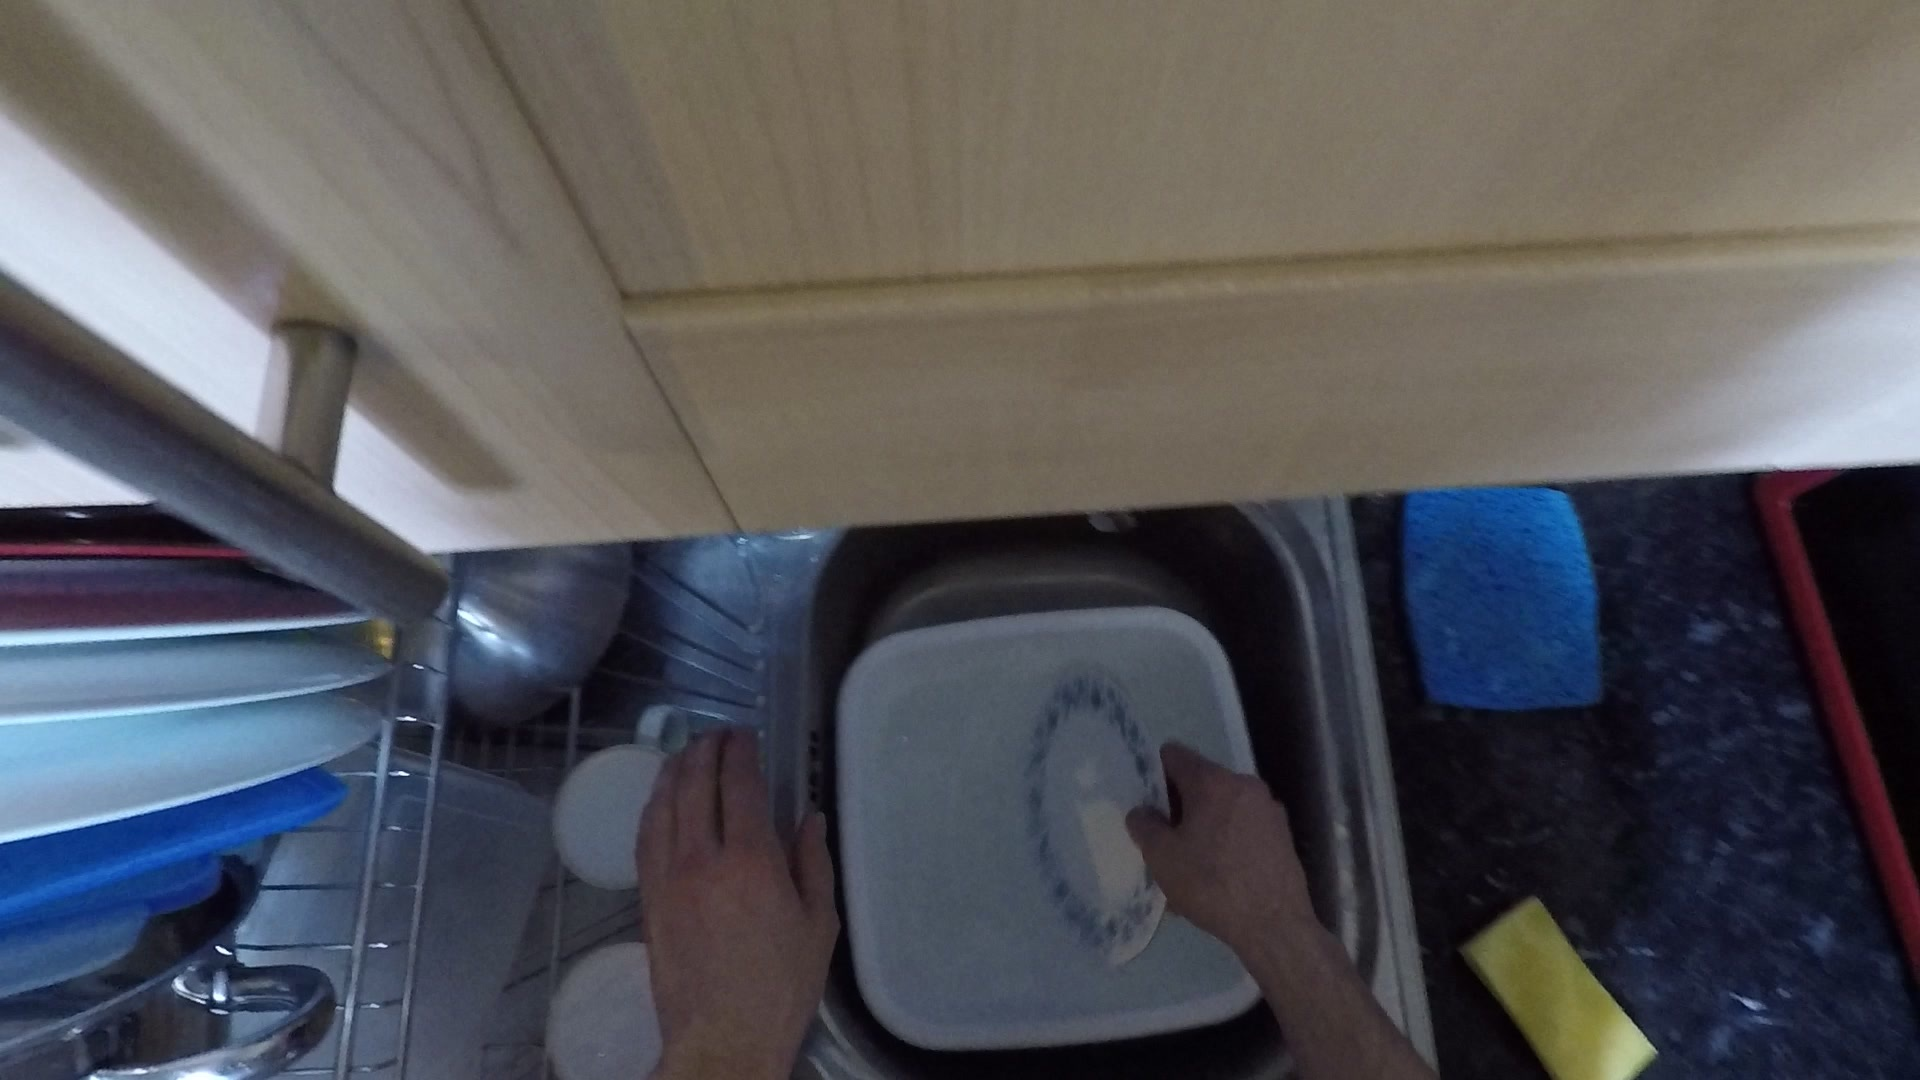

In [3]:
DEMO_IMAGE = "data/samples/0000004831.jpg"
Image(filename=DEMO_IMAGE)

In [7]:
!python detect.py --cfg cfg/yolov3-hand-anchors.cfg --names data/ego-hand.names --source data/samples/0000004831.jpg --output output/demo-better --weights weights/best-scrach-100.pt --save-txt --iou-thres 0.3 --conf-thres 0.6

Namespace(agnostic_nms=False, augment=False, cfg='cfg/yolov3-hand-anchors.cfg', classes=None, conf_thres=0.6, device='', fourcc='mp4v', half=False, img_size=512, iou_thres=0.3, names='data/ego-hand.names', output='output/demo-better', save_txt=True, soft_nms=False, soft_thres=0.05, source='data/samples/0000004831.jpg', view_img=False, weights='weights/best-scrach-100.pt')
Using CPU

Model Summary: 222 layers, 6.15237e+07 parameters, 6.15237e+07 gradients
image 1/1 data\samples\0000004831.jpg:
prediction[0].shape:  torch.Size([10080, 6])

img.shape[2]:  torch.Size([320, 512])
det[:, :4]:  tensor([[306.73877, 200.14633, 340.96399, 281.96677],
        [162.43747, 183.09239, 229.96335, 318.85870]])
im0.shape:  (1080, 1920, 3)
320x512 2 hands, Done. (1.928s)
Results saved to f:\PROJECT\project-diary\yolov3\output/demo-better
Done. (2.036s)


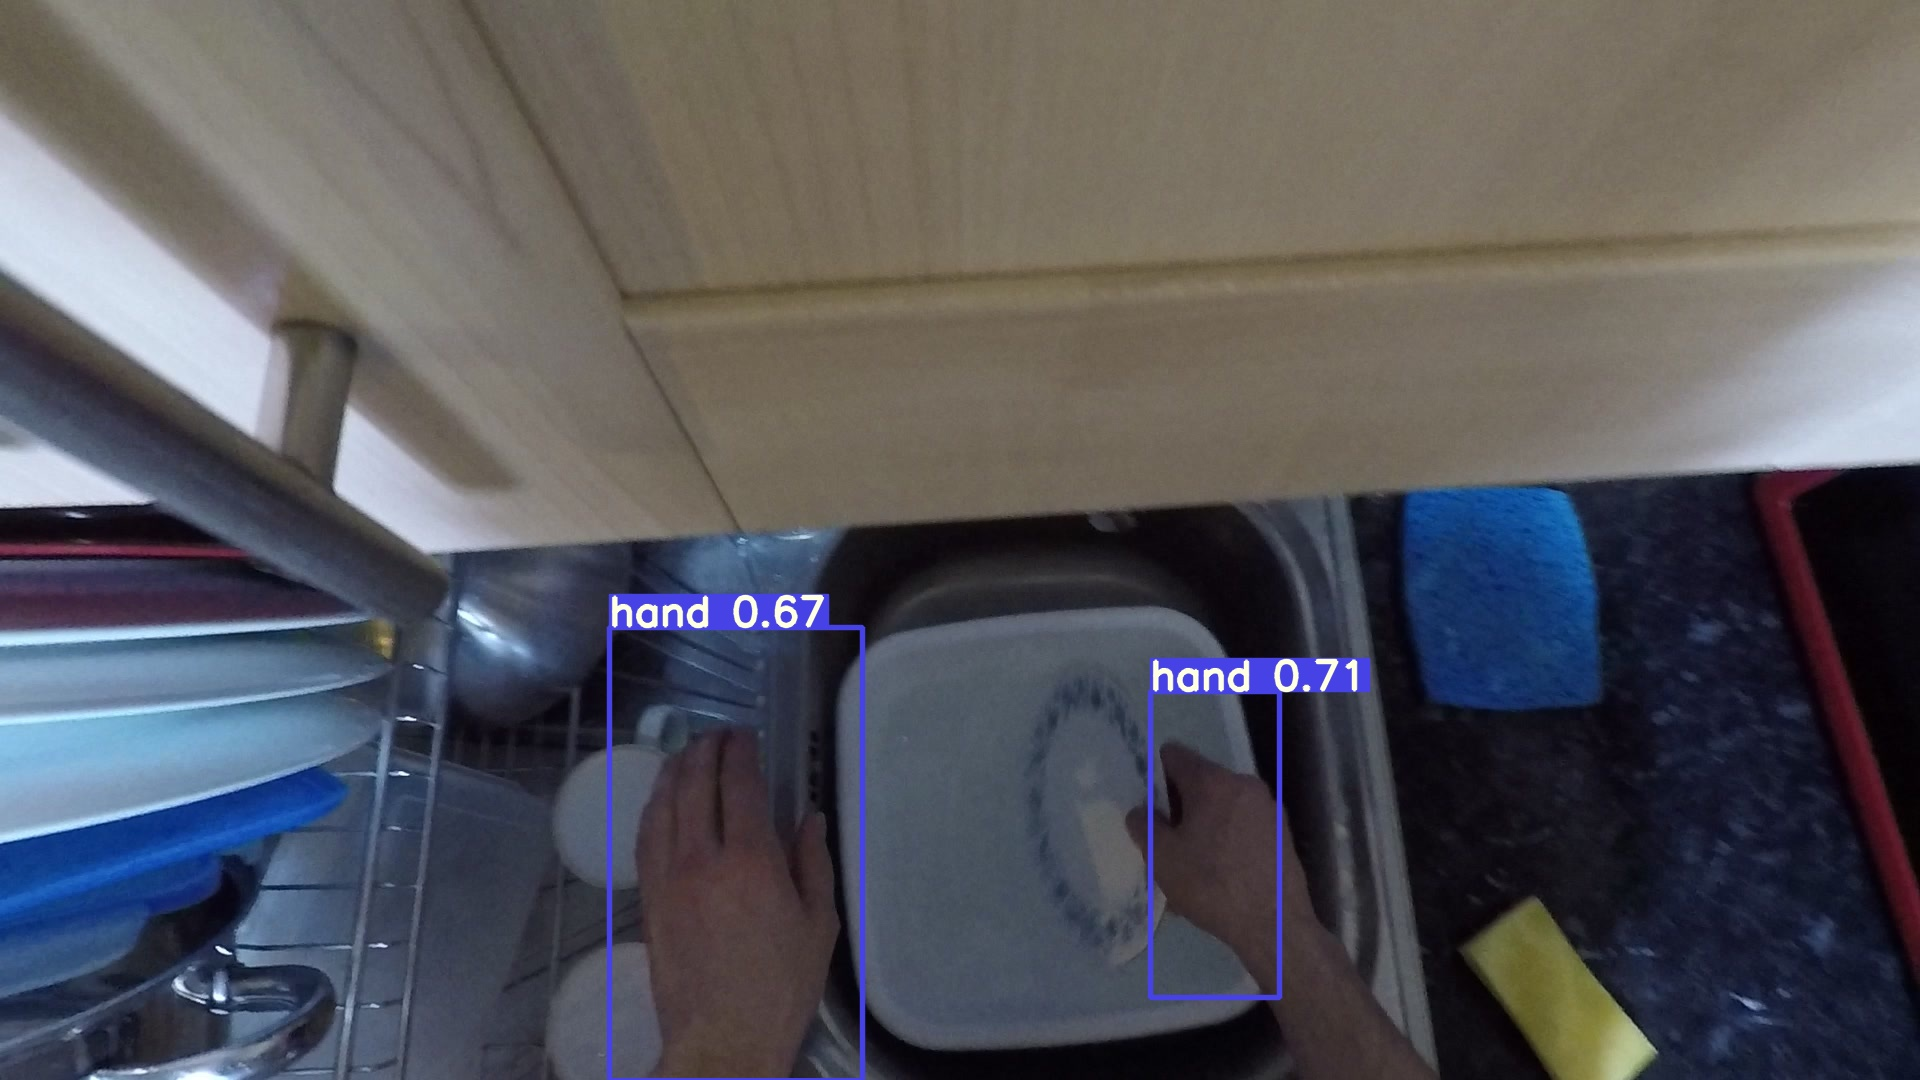

In [8]:
Image(filename="output/demo-better/0000004831.jpg")

In [4]:
!python detect.py --cfg cfg/yolov3-hand-anchors.cfg --names data/ego-hand.names --source data/samples/0000004831.jpg --output output/demo --weights weights/yolov3-egohand-noflip.pt --save-txt

Namespace(agnostic_nms=False, augment=False, cfg='cfg/yolov3-hand-anchors.cfg', classes=None, conf_thres=0.3, device='', fourcc='mp4v', half=False, img_size=512, iou_thres=0.6, names='data/ego-hand.names', output='output/demo', save_txt=True, soft_nms=False, soft_thres=0.05, source='data/samples/0000004831.jpg', view_img=False, weights='weights/yolov3-egohand-noflip.pt')
Using CPU

Model Summary: 222 layers, 6.15237e+07 parameters, 6.15237e+07 gradients
image 1/1 data\samples\0000004831.jpg: 320x512 2 hands, Done. (2.096s)
Results saved to f:\PROJECT\project-diary\yolov3\output/demo
Done. (2.233s)


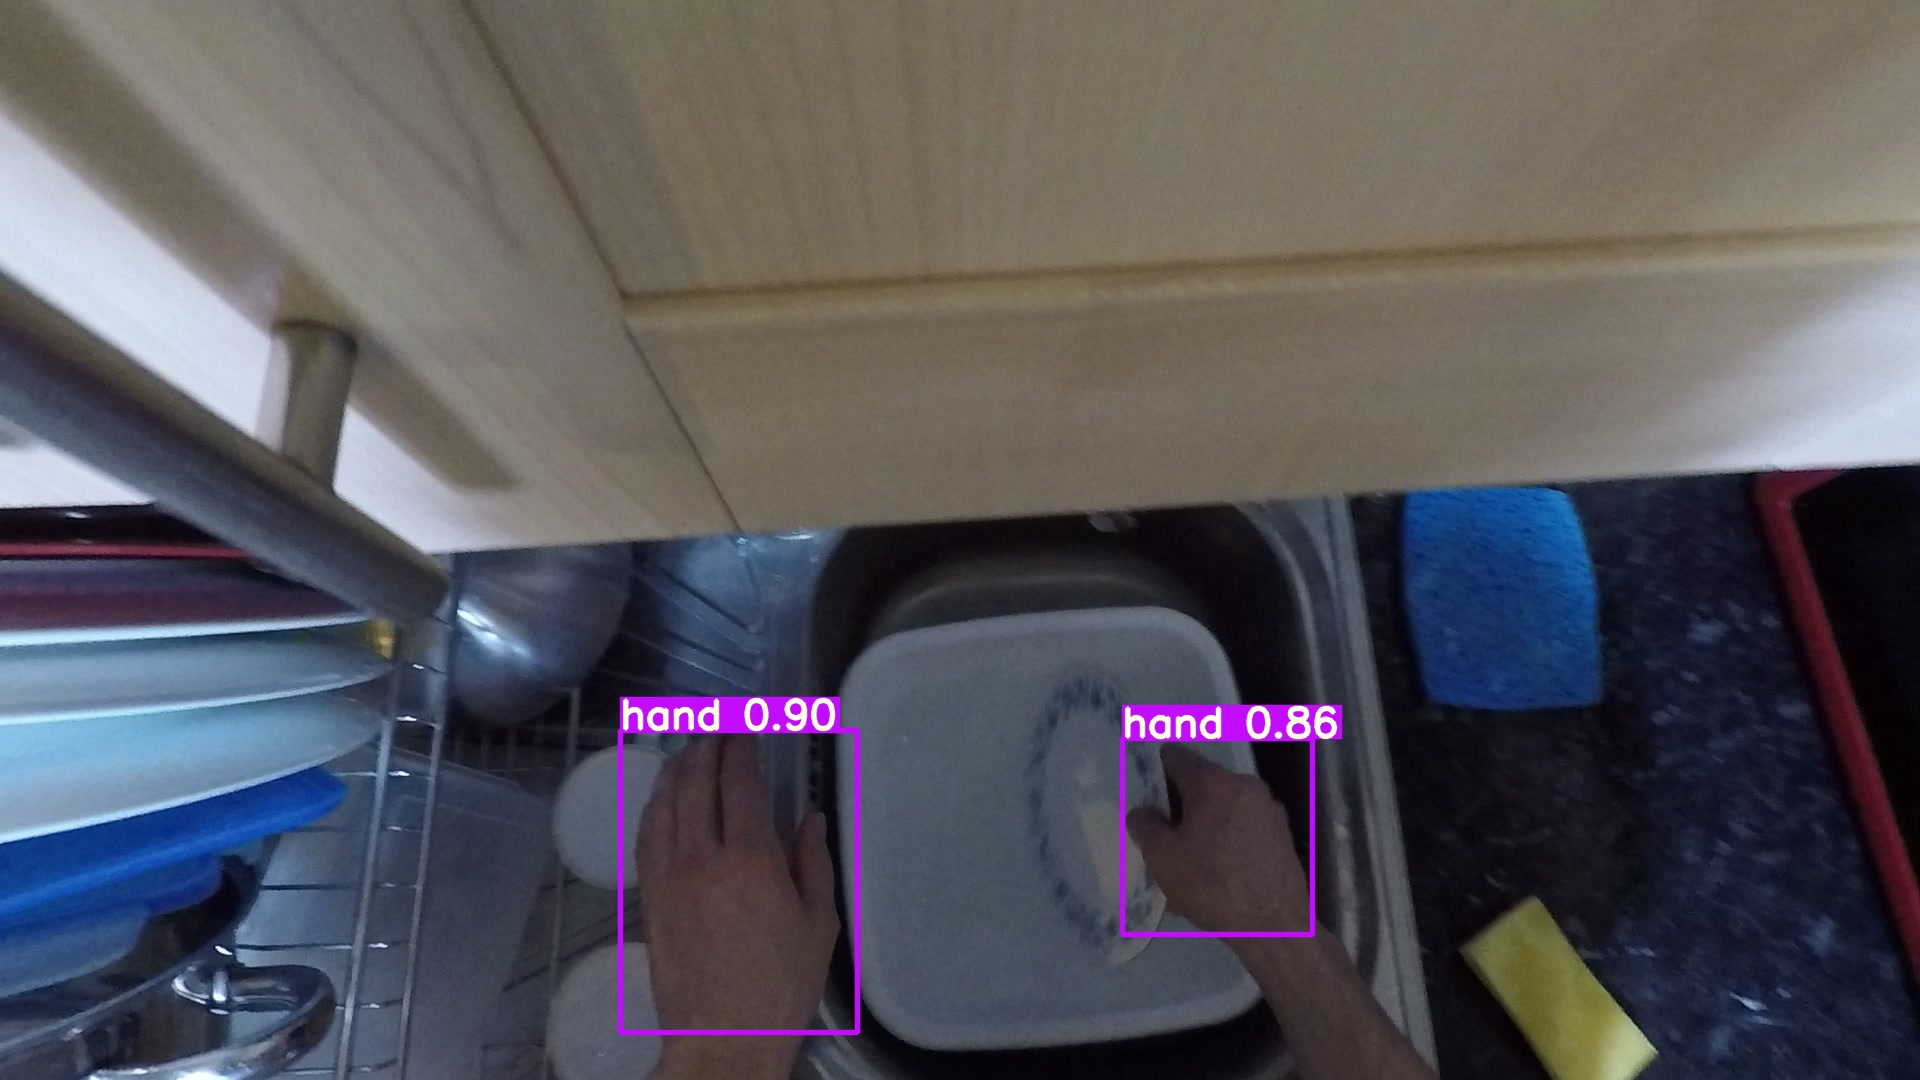

In [5]:
Image(filename="output/demo/0000004831.jpg")

In [6]:
# 使用--save-txt选项，把检测信息提取出来，结果保存在输出图片同一个路径
# 从detect.py lin 128知保存格式是：

In [7]:
# <imagename>.txt
# cls, xcenter, ycenter, w, h

In [9]:
with open("output/demo/0000004831.txt", 'r') as f:
    for line in f:
        line = line[:-1].split()    # Strip '\n'
        line.pop(1)
        line[0] = int(line[0])
        line[1:] = [float(i) for i in line[1:]]
        print(line)

[0, 0.384635, 0.815741, 0.123438, 0.27963]
[0, 0.633854, 0.774074, 0.0989583, 0.181481]


In [10]:
# <imagename>_unnorm.txt
# cls, left-top-x, left-top-y, right-bot-x, right-bot-y

In [11]:
bboxes_unnorm = []

with open("output/demo/0000004831_unnorm.txt", 'r') as f:
    for line in f:
        line = line[:-1].split()    # Strip '\n'
        line.pop(1)
        line[:] = [int(i) for i in line[:]]
        bboxes_unnorm.append(line)
        print(line)

[0, 620, 730, 857, 1032]
[0, 1122, 738, 1312, 934]


In [12]:
bboxes_unnorm

[[0, 620, 730, 857, 1032], [0, 1122, 738, 1312, 934]]

In [13]:
# 裁剪出bbox的一块图片
def crop_bbox(img_path, bboxes, save_path):
    if os.path.exists(save_path):
        shutil.rmtree(save_path)  # delete output folder
    os.makedirs(save_path)  # make new output folder
    
    img_name = os.path.basename(img_path)
    img = cv2.imread(img_path)
    bboxes_path = []

    for i, bbox in enumerate(bboxes):
        xyxy = bbox[1:]
        crop_img = img[xyxy[1]:xyxy[3], xyxy[0]:xyxy[2]]
        save_name = os.path.join(save_path, img_name[:-4] + '_{}.jpg'.format(i))
        cv2.imwrite(save_name, crop_img)
        bboxes_path.append(save_name)

    return bboxes_path

In [14]:
bboxes_paths = crop_bbox(DEMO_IMAGE, bboxes_unnorm, 'output/demo/bboxes')

In [15]:
# 显示，白色边缘是显示问题

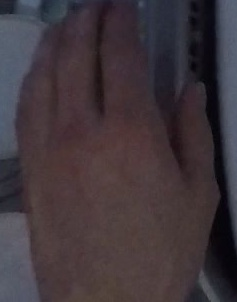

In [16]:
Image(filename=bboxes_paths[0], width=600)

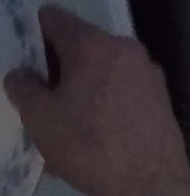

In [17]:
Image(filename=bboxes_paths[1])

In [15]:
# 结果是P30训练出来的模型并没有对bbox对进一步的区分，这个适合检测任务的模型不太适合做分类，还要继续思考。

## soft-NMS

In [2]:
# To overcome the problem that hands are close to each other

In [1]:
%cd yolov3/

f:\PROJECT\project-diary\yolov3


In [2]:
# 难点图片
!python detect.py --cfg cfg/yolov3-hand-anchors.cfg --names data/ego-hand.names --source data/samples/Hand-Overlap.jpg --output output/softnms --weights weights/yolov3-egohand-noflip.pt --save-txt 

Namespace(agnostic_nms=False, augment=False, cfg='cfg/yolov3-hand-anchors.cfg', classes=None, conf_thres=0.3, device='', fourcc='mp4v', half=False, img_size=512, iou_thres=0.6, names='data/ego-hand.names', output='output/softnms', save_txt=True, soft_nms=False, soft_thres=0.05, source='data/samples/Hand-Overlap.jpg', view_img=False, weights='weights/yolov3-egohand-noflip.pt')
Using CPU

Model Summary: 222 layers, 6.15237e+07 parameters, 6.15237e+07 gradients
image 1/1 data\samples\Hand-Overlap.jpg: 320x512 1 hands, Done. (1.983s)
Results saved to f:\PROJECT\project-diary\yolov3\output/softnms
Done. (2.159s)


In [10]:
# softnms
!python detect.py --cfg cfg/yolov3-hand-anchors.cfg --names data/ego-hand.names --source data/samples/Hand-Overlap.jpg --output output/softnms/softnms --weights weights/yolov3-egohand-noflip.pt --save-txt --soft-nms --soft-thres 0.6 --conf-thres 0.001

Namespace(agnostic_nms=False, augment=False, cfg='cfg/yolov3-hand-anchors.cfg', classes=None, conf_thres=0.001, device='', fourcc='mp4v', half=False, img_size=512, iou_thres=0.6, names='data/ego-hand.names', output='output/softnms/softnms', save_txt=True, soft_nms=True, soft_thres=0.6, source='data/samples/Hand-Overlap.jpg', view_img=False, weights='weights/yolov3-egohand-noflip.pt')
Using CPU

Model Summary: 222 layers, 6.15237e+07 parameters, 6.15237e+07 gradients
image 1/1 data\samples\Hand-Overlap.jpg: 320x512 1 hands, Done. (1.657s)
Results saved to f:\PROJECT\project-diary\yolov3\output/softnms/softnms
Done. (1.760s)


In [ ]:
# An image with overlapping hands

In [104]:
!python detect.py --cfg cfg/yolov3-hand-anchors.cfg --names data/ego-hand.names --source data/samples/0000003541.jpg --output output/softnms --weights weights/yolov3-egohand-epoch4.pt --save-txt

Namespace(agnostic_nms=False, augment=False, cfg='cfg/yolov3-hand-anchors.cfg', classes=None, conf_thres=0.3, device='', fourcc='mp4v', half=False, img_size=512, iou_thres=0.6, names='data/ego-hand.names', output='output/softnms', save_txt=True, soft_nms=False, source='data/samples/0000003541.jpg', view_img=False, weights='weights/yolov3-egohand-epoch4.pt')
Using CPU

Model Summary: 222 layers, 6.15237e+07 parameters, 6.15237e+07 gradients
image 1/1 data\samples\0000003541.jpg:
prediction[0].shape:  torch.Size([10080, 6])

x:  tensor([[281.40088, 250.61342,  48.22846,  62.88704,   0.32970,   0.98320]])

prediction:  tensor([[[2.46929e+01, 2.62372e+01, 4.28044e+01, 4.48542e+01, 1.05514e-05, 9.85097e-01],
         [4.82792e+01, 2.12269e+01, 6.29941e+01, 3.35078e+01, 2.27893e-05, 9.84388e-01],
         [8.01887e+01, 2.19943e+01, 6.45047e+01, 3.23072e+01, 1.80200e-05, 9.85443e-01],
         ...,
         [4.92360e+02, 3.15060e+02, 3.71245e+01, 2.82034e+01, 3.77517e-06, 9.85103e-01],
      

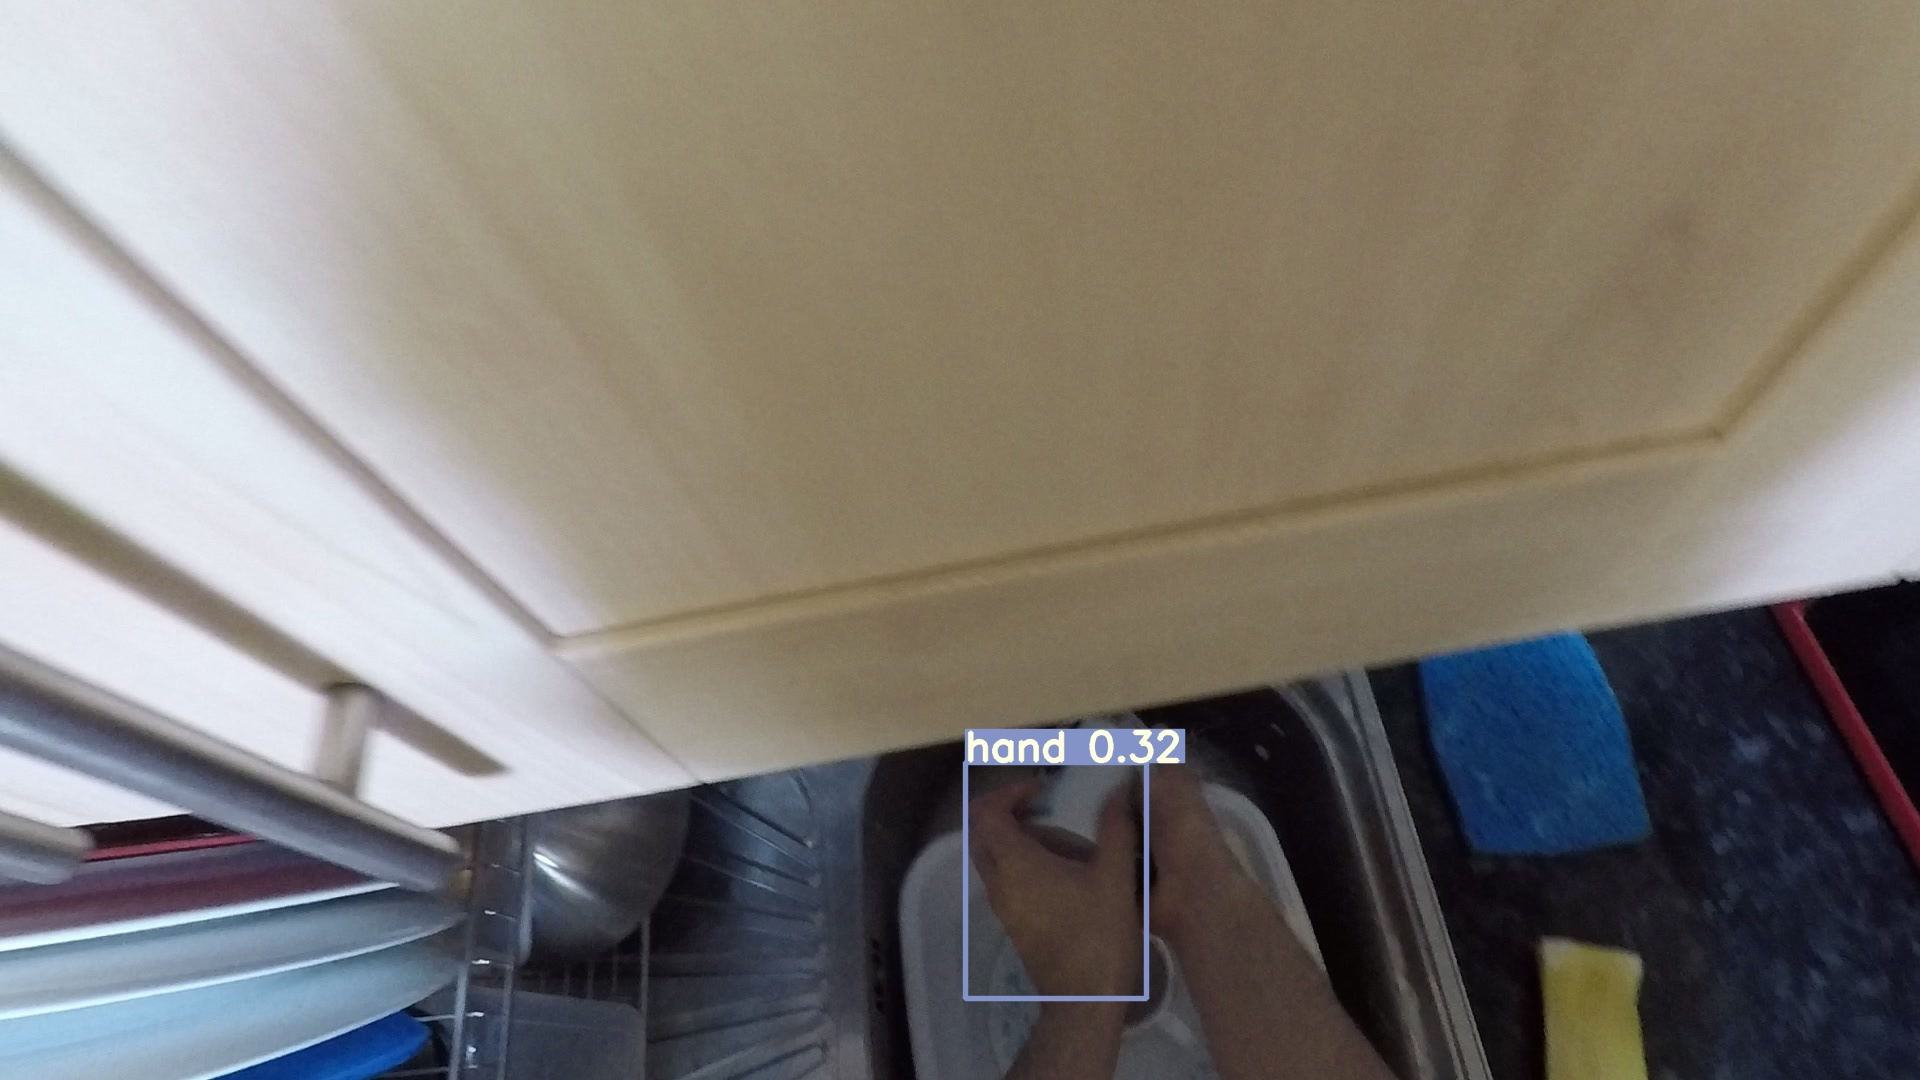

In [105]:
Image(filename="output/softnms/0000003541.jpg")

In [102]:
# Only one hand

In [5]:
# weights file: full training for 100 epochs
!python detect.py --cfg cfg/yolov3-hand-anchors.cfg --names data/ego-hand.names --source data/samples/0000003541.jpg --output output/softnms-better --weights weights/yolov3-egohand-epoch100.pt --save-txt 

Namespace(agnostic_nms=False, augment=False, cfg='cfg/yolov3-hand-anchors.cfg', classes=None, conf_thres=0.3, device='', fourcc='mp4v', half=False, img_size=512, iou_thres=0.6, names='data/ego-hand.names', output='output/softnms-better', save_txt=True, soft_nms=False, soft_thres=0.05, source='data/samples/0000003541.jpg', view_img=False, weights='weights/yolov3-egohand-epoch100.pt')
Using CPU

Model Summary: 222 layers, 6.15237e+07 parameters, 6.15237e+07 gradients
image 1/1 data\samples\0000003541.jpg:
prediction[0].shape:  torch.Size([10080, 6])

img.shape[2]:  torch.Size([320, 512])
det[:, :4]:  tensor([[254.34171, 223.78712, 305.85666, 280.79623],
        [296.30182, 215.91493, 333.37531, 269.40790]])
im0.shape:  (1080, 1920, 3)
320x512 2 hands, Done. (1.883s)
Results saved to f:\PROJECT\project-diary\yolov3\output/softnms-better
Done. (2.052s)


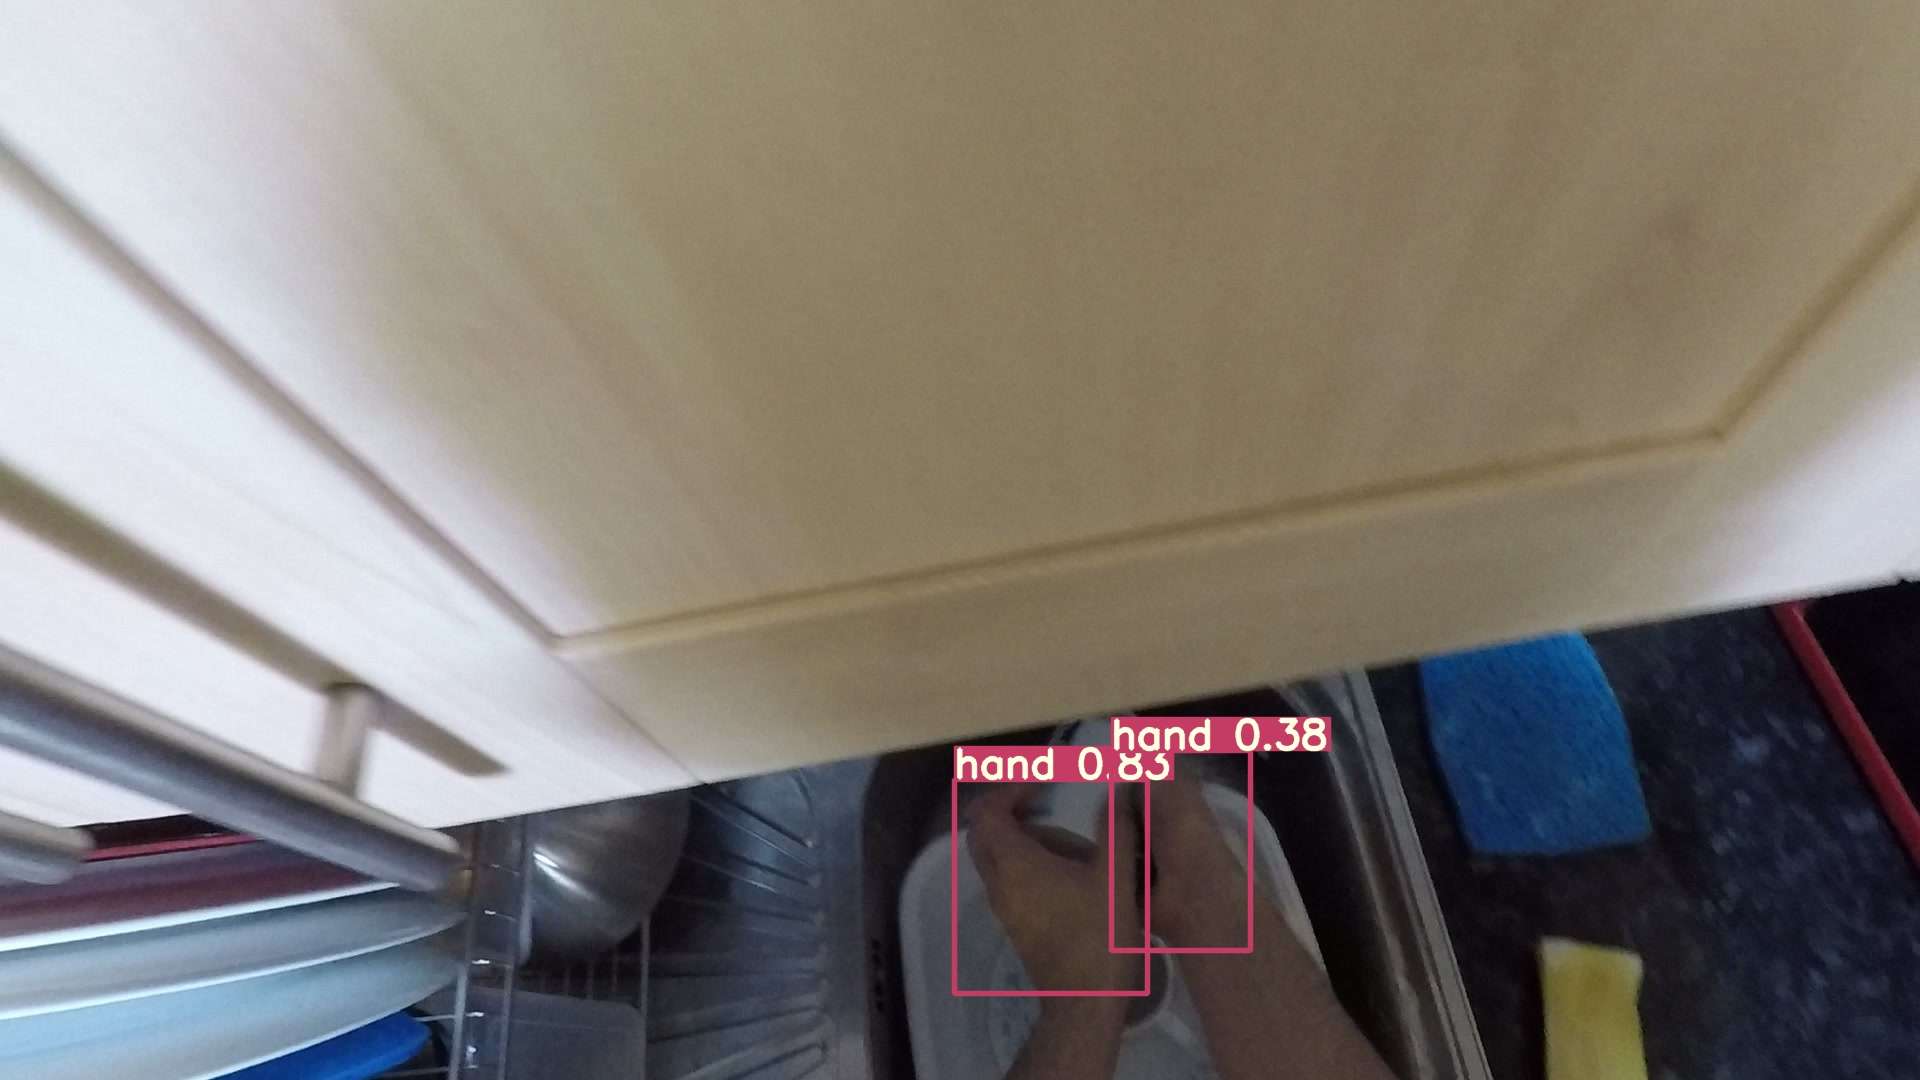

In [6]:
# 我训练出来的效果更好
Image(filename="output/softnms-better/0000003541.jpg")

In [13]:
!python detect.py --cfg cfg/yolov3-hand-anchors.cfg --names data/ego-hand.names --source data/samples/0000003541.jpg --output output/softnms --weights weights/yolov3-egohand-epoch4.pt --save-txt --conf-thres 0.05

Namespace(agnostic_nms=False, augment=False, cfg='cfg/yolov3-hand-anchors.cfg', classes=None, conf_thres=0.05, device='', fourcc='mp4v', half=False, img_size=512, iou_thres=0.6, names='data/ego-hand.names', output='output/softnms', save_txt=True, soft_nms=False, soft_thres=0.05, source='data/samples/0000003541.jpg', view_img=False, weights='weights/yolov3-egohand-epoch4.pt')
Using CPU

Model Summary: 222 layers, 6.15237e+07 parameters, 6.15237e+07 gradients
image 1/1 data\samples\0000003541.jpg:
prediction[0].shape:  torch.Size([10080, 6])

img.shape[2]:  torch.Size([320, 512])
det[:, :4]:  tensor([[256.55109, 219.59157, 307.11633, 286.04568],
        [297.38528, 215.49600, 327.51730, 250.20572]])
im0.shape:  (1080, 1920, 3)
320x512 2 hands, Done. (1.828s)
Results saved to f:\PROJECT\project-diary\yolov3\output/softnms
Done. (1.913s)


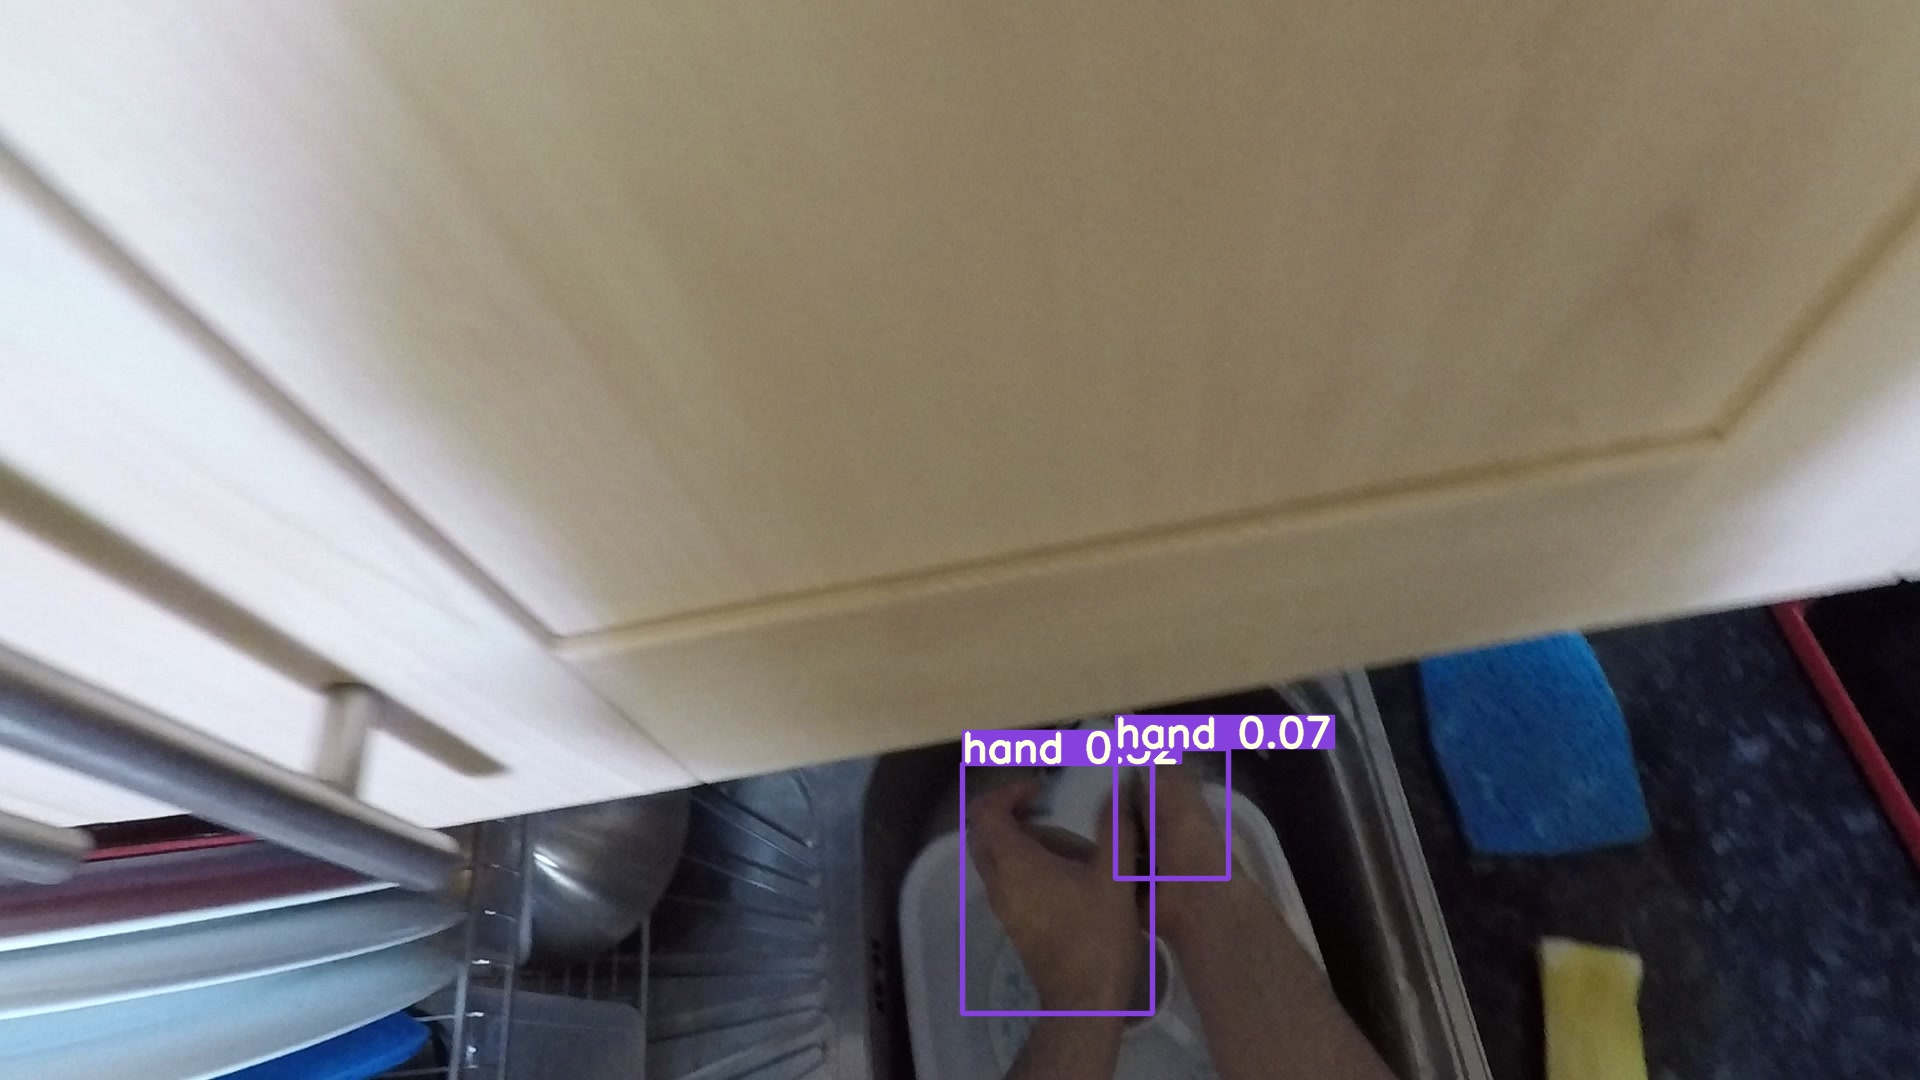

In [14]:
Image(filename="output/softnms/0000003541.jpg")

In [108]:
# Two hands but may not be able to address more overlap

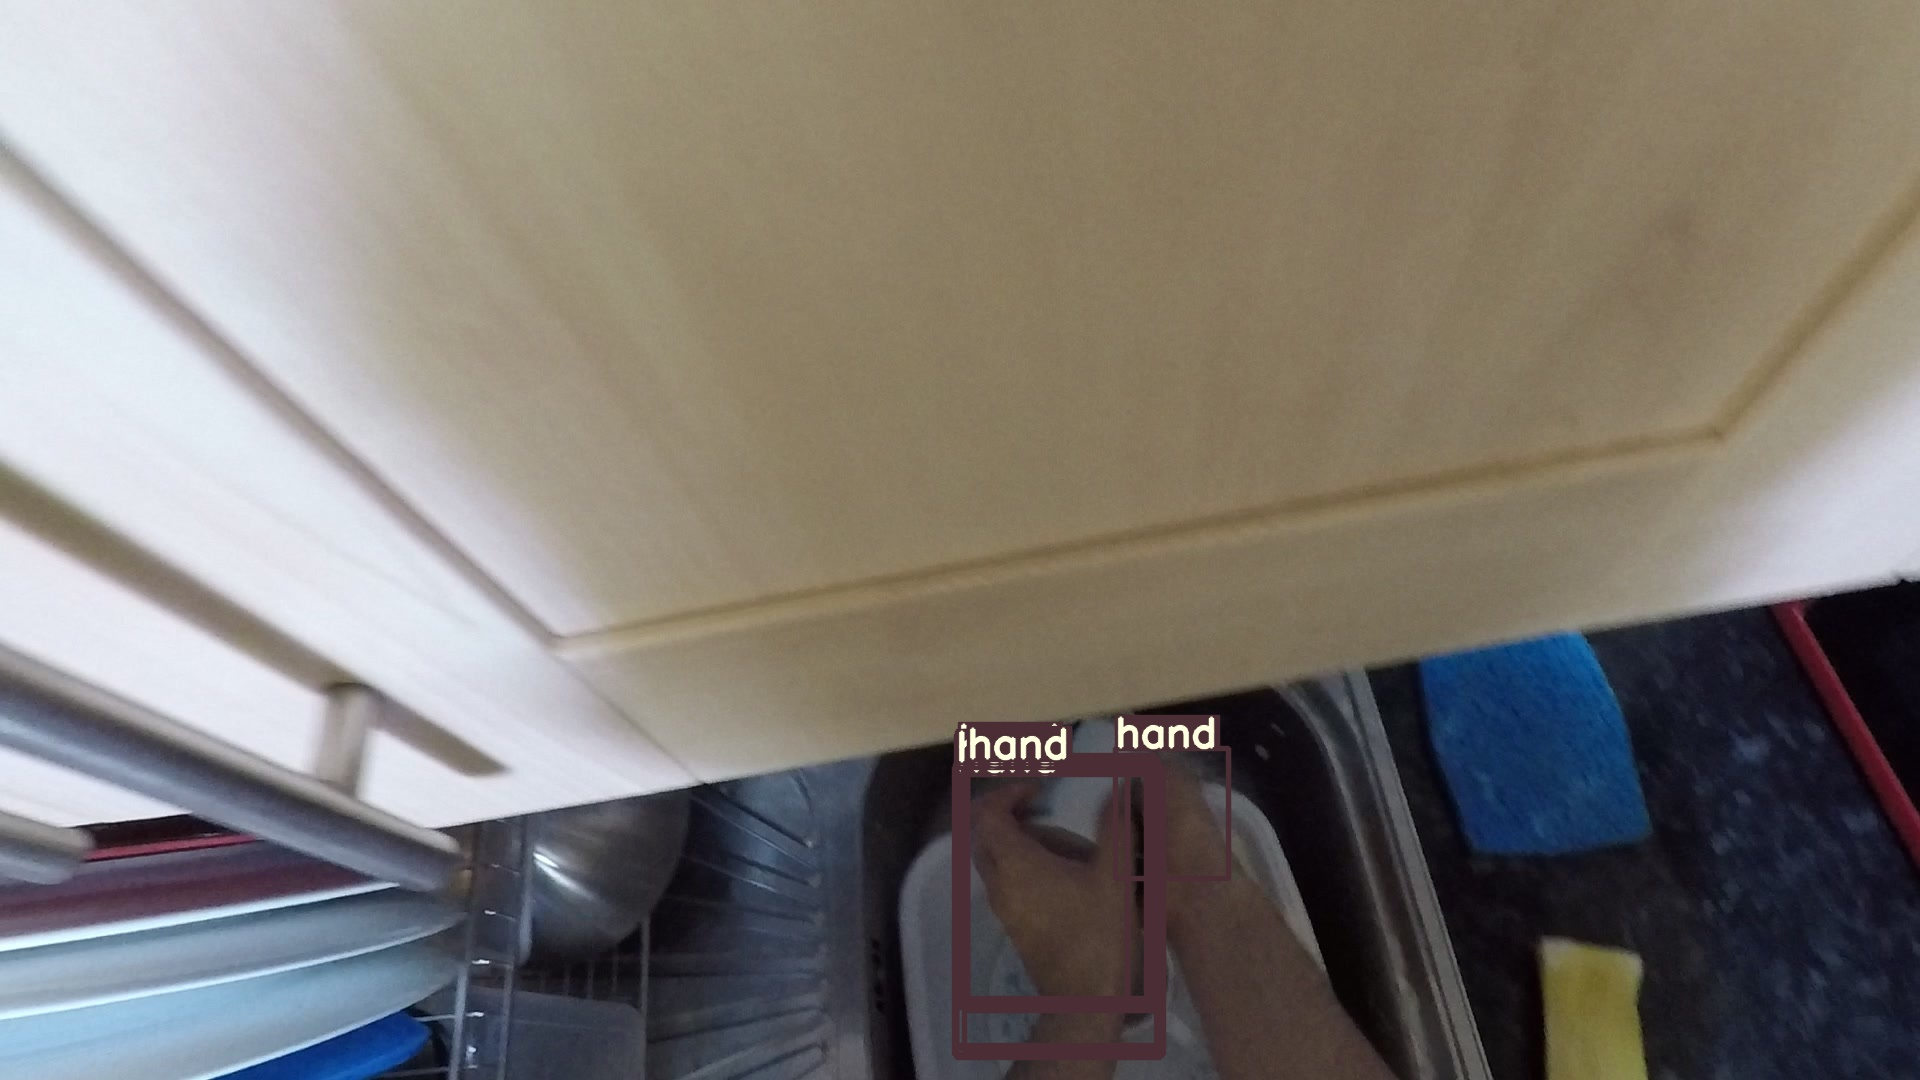

In [287]:
boxes = torch.load("output/demo/boxes.pt")
scores = torch.load("output/demo/scores.pt")

img = cv2.imread('data/samples/0000003541.jpg')
colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(1)]
boxes = scale_coords(torch.Size([320, 512]), boxes, img.shape).round()
for box in boxes:
    plot_one_box(box, img, label='hand', color=colors[0])
cv2.imwrite('output/softnms/test.jpg', img)
Image(filename='output/softnms/test.jpg')

In [320]:
def soft_nms(bboxes, bscores, sigma=0.5, thres=0.001):
    """Soft NMS algorithm under PyTorch frame.
    Reference:
        https://github.com/DocF/Soft-NMS/blob/master/softnms_pytorch.py
    Arguments:
        boxes:  boxes coordinate tensor. Format: (x1,y1,x2,y2)
        scores: boxes score tensor
        sigma:  variance of Guassian function
        thres:  discard boxes with scores less than the threshold
    Return:
        the index of the selected boxes
    """
    boxes = bboxes.clone()
    scores = bscores.clone()
    cuda = 1 if torch.cuda.is_available() else 0
    if cuda:
        boxes = boxes.cuda()
        scores = scores.cuda()
    
    # Indexes concatenate boxes with the last column
    N = boxes.shape[0]
    if cuda:
        indices = torch.arange(0, N, dtype=torch.float).cuda().view(N, 1)
    else:
        indices = torch.arange(0, N, dtype=torch.float).view(N, 1)
    boxes = torch.cat((boxes, indices), dim=1)

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    areas = (x2-x1+1)*(y2-y1+1)

    for i in range(N):
        # intermediate params for later params exchange
        tscore = scores[i].clone()
        pos = i+1

        # Exchange later max and current index
        if i != N - 1:
            max_score, max_pos = torch.max(scores[pos:], dim=0)
            if tscore < max_score:
                boxes[i], boxes[max_pos.item() + i + 1] = boxes[max_pos.item() + i + 1].clone(), boxes[i].clone()
                scores[i], scores[max_pos.item() + i + 1] = scores[max_pos.item() + i + 1].clone(), scores[i].clone()
                areas[i], areas[max_pos + i + 1] = areas[max_pos + i + 1].clone(), areas[i].clone()
        
        # IoU calculation
        xx1 = torch.max(boxes[i, 0], boxes[pos:, 0])    # inter left-top x
        yy1 = torch.max(boxes[i, 1], boxes[pos:, 1])    # inter left-top y
        xx2 = torch.min(boxes[i, 2], boxes[pos:, 2])    # inter right-bot x
        yy2 = torch.min(boxes[i, 3], boxes[pos:, 3])    # inter right-bot y

        zero_tensor = torch.tensor([0.0]).cuda() if cuda else torch.tensor([0.0])
        w = torch.max(zero_tensor, xx2-xx1+1)
        h = torch.max(zero_tensor, yy2-yy1+1)

        inter = w*h
        ovr = torch.div(inter, (areas[i] + areas[pos:] - inter))

        # Gaussian decay
        weight = torch.exp(-(ovr**2)/sigma)
        scores[pos:] = weight * scores[pos:]

    # Score thresholding
    keep = boxes[:, 4][scores > thres].type(torch.LongTensor)

    return keep

In [321]:
boxes = torch.load("output/demo/boxes.pt")
scores = torch.load("output/demo/scores.pt")

cuda = 1 if torch.cuda.is_available() else 0
keep = soft_nms(boxes, scores, sigma=0.5, thres=0.05)
soft_boxes = boxes[keep, :]
soft_boxes

tensor([[257.28665, 219.16989, 305.51511, 282.05695],
        [297.38528, 215.49600, 327.51730, 250.20572]])

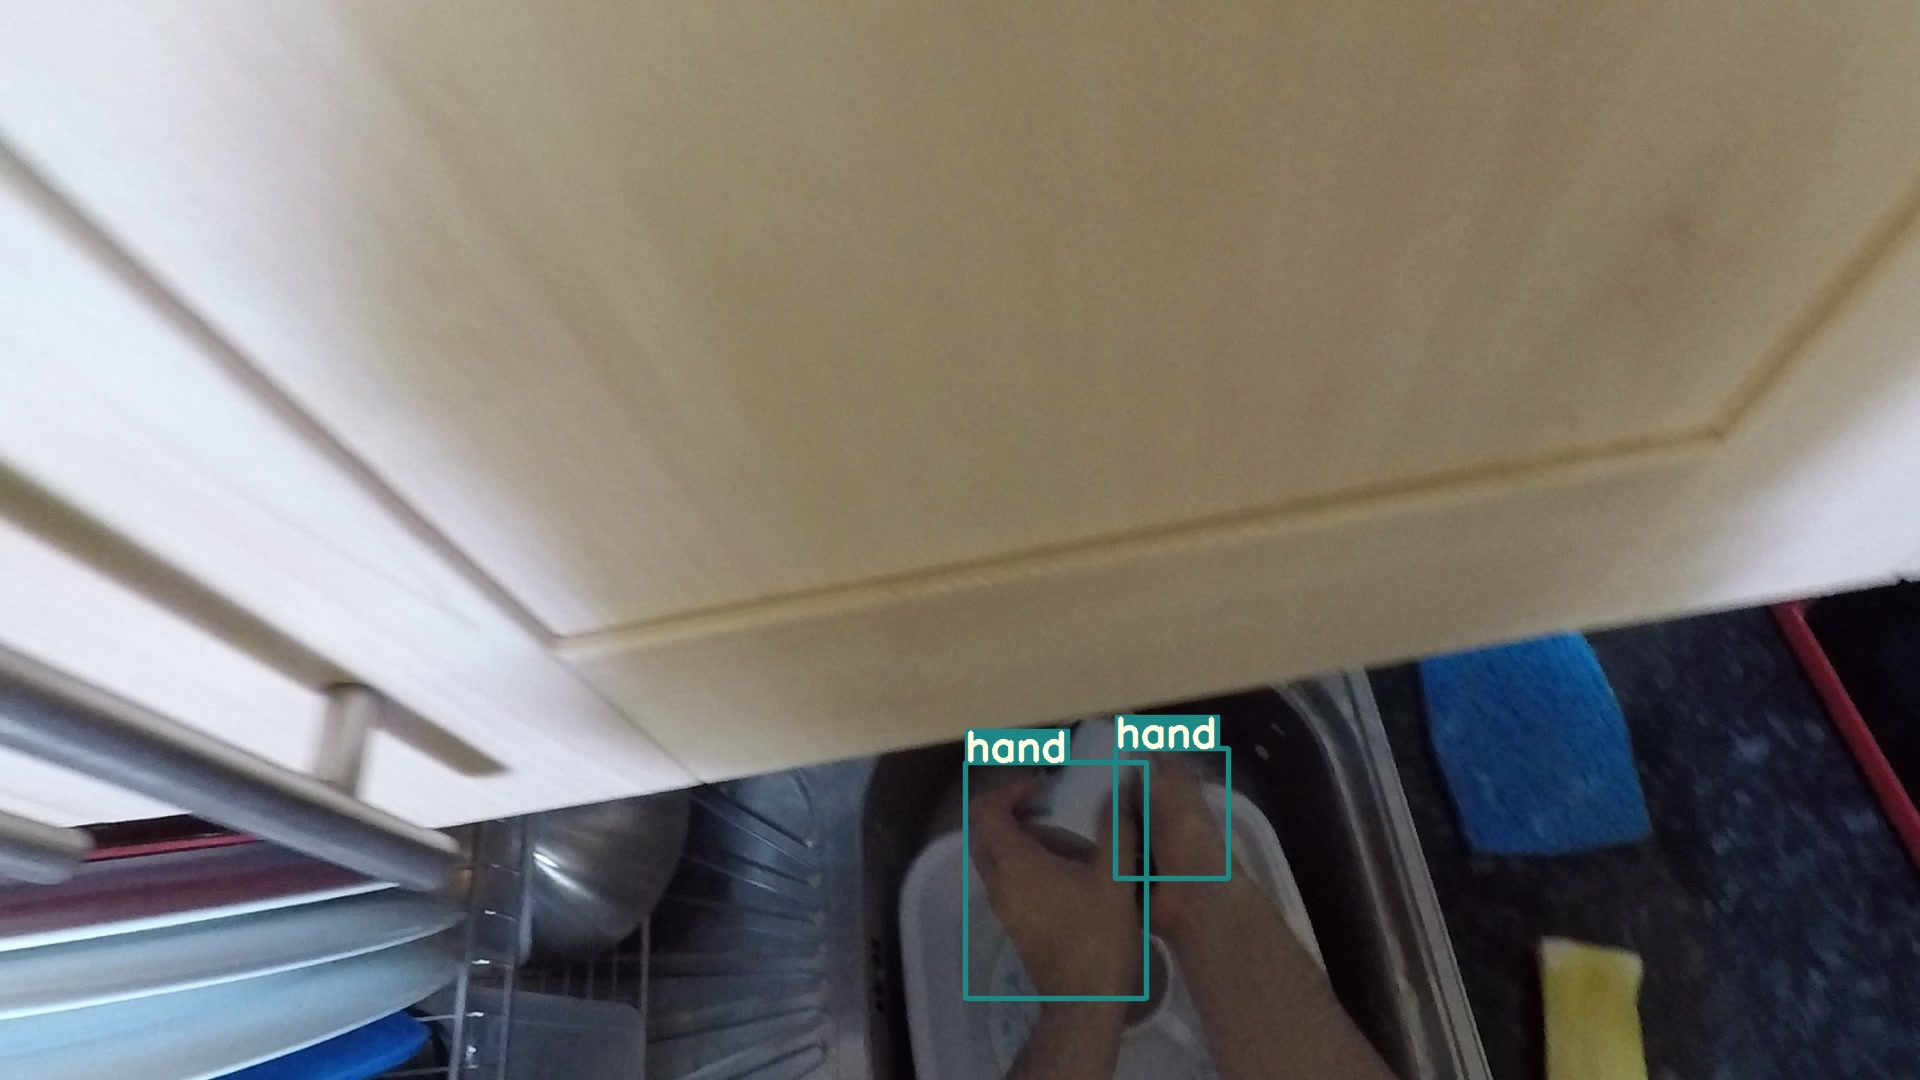

In [322]:
img = cv2.imread('data/samples/0000003541.jpg')
colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(1)]
soft_boxes = scale_coords(torch.Size([320, 512]), soft_boxes, img.shape).round()
for box in soft_boxes:
    plot_one_box(box, img, label='hand', color=colors[0])
cv2.imwrite('output/softnms/test_softnms.jpg', img)
Image(filename='output/softnms/test_softnms.jpg')

In [323]:
# Integration with detect.py and util.py 

In [6]:
!python detect.py --cfg cfg/yolov3-hand-anchors.cfg --names data/ego-hand.names --source data/samples/0000003541.jpg --output output/softnms --weights weights/yolov3-egohand-epoch4.pt --save-txt --soft-nms --soft-thres 0.6 --conf-thres 0.05

Namespace(agnostic_nms=False, augment=False, cfg='cfg/yolov3-hand-anchors.cfg', classes=None, conf_thres=0.05, device='', fourcc='mp4v', half=False, img_size=512, iou_thres=0.6, names='data/ego-hand.names', output='output/softnms', save_txt=True, soft_nms=True, soft_thres=0.6, source='data/samples/0000003541.jpg', view_img=False, weights='weights/yolov3-egohand-epoch4.pt')
Using CPU

Model Summary: 222 layers, 6.15237e+07 parameters, 6.15237e+07 gradients
image 1/1 data\samples\0000003541.jpg: 
prediction[0].shape:  torch.Size([10080, 6])

img.shape[2]:  torch.Size([320, 512]) 
det[:, :4]:  tensor([[256.55109, 219.59157, 307.11633, 286.04568],
        [297.38528, 215.49600, 327.51730, 250.20572]]) 
im0.shape:  (1080, 1920, 3)
320x512 2 hands, Done. (1.808s)
Results saved to f:\PROJECT\project-diary\yolov3\output/softnms
Done. (1.896s)


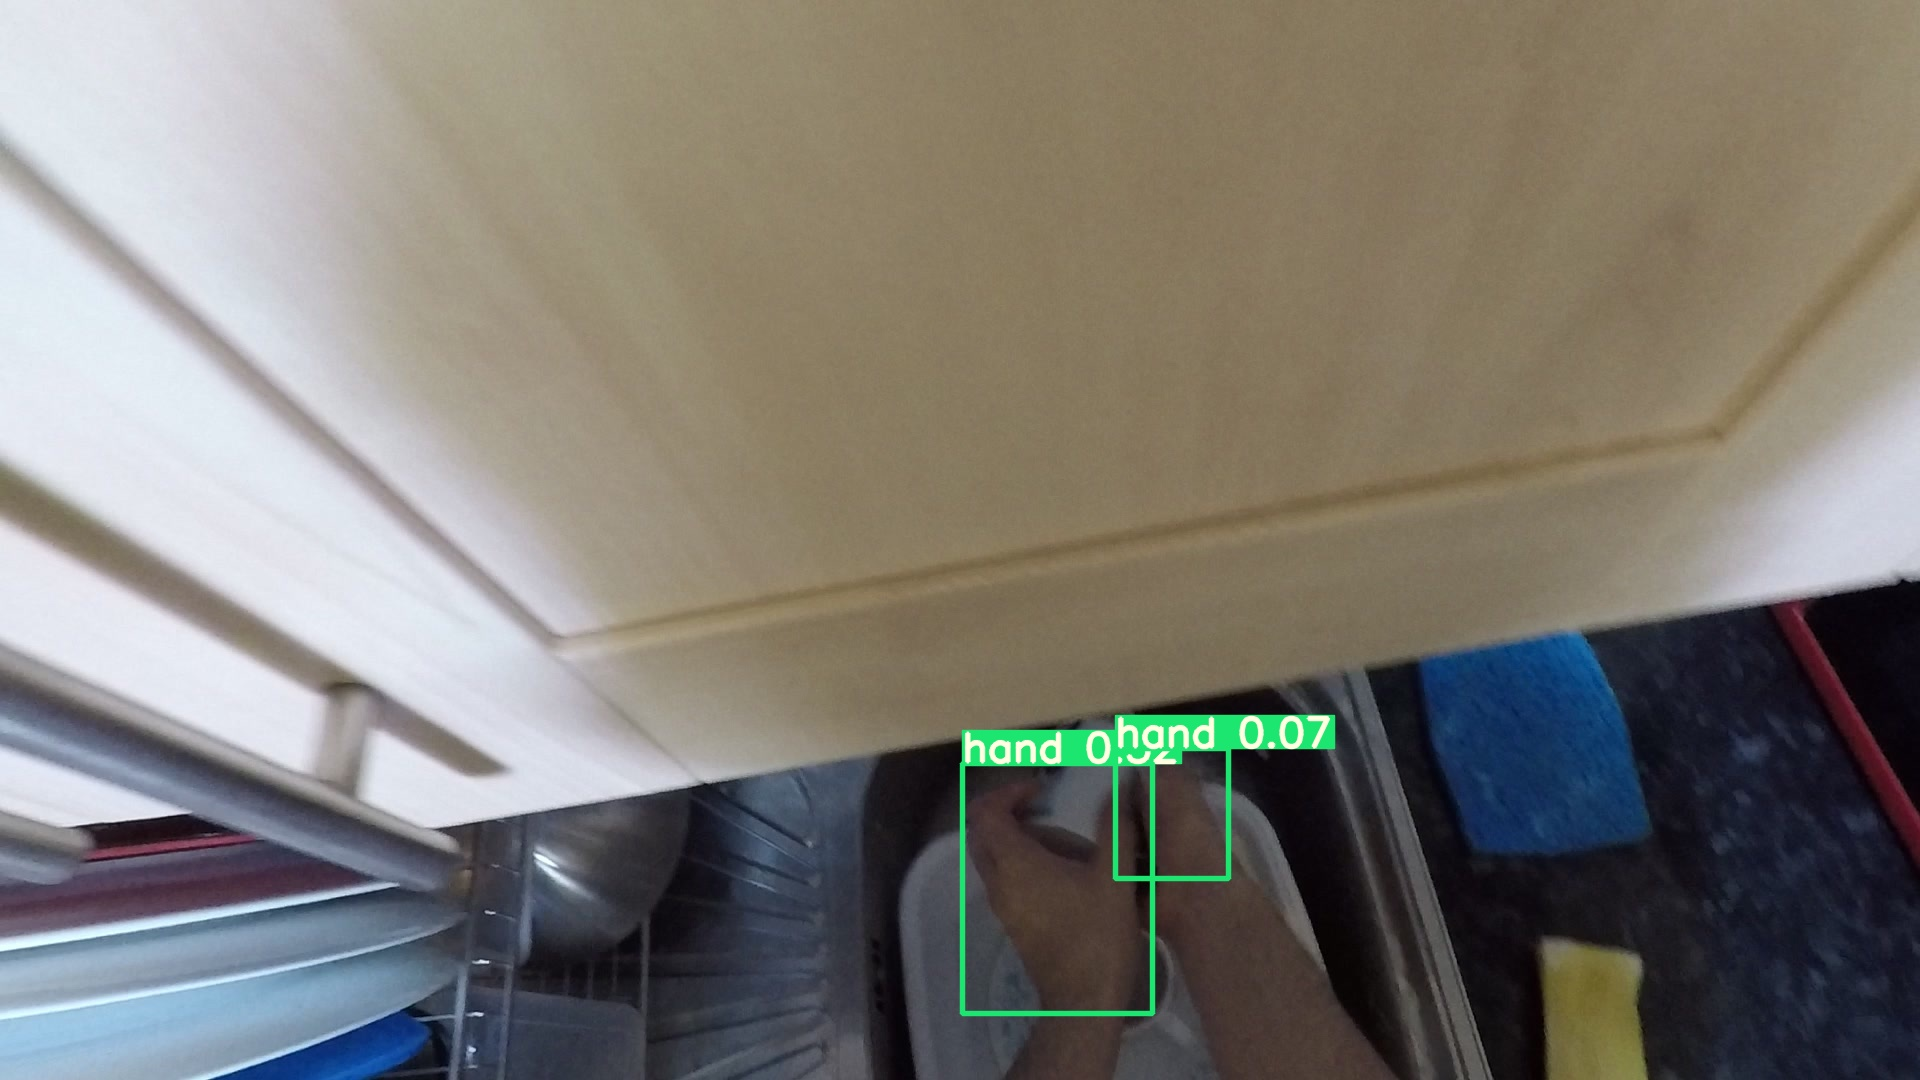

In [7]:
Image(filename='output/softnms/0000003541.jpg')